In [1]:
# SET UP Fastai
%pip install -Uqq fastbook
%pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import csv
import cv2
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
fastcore version 1.5.29 installed
fastai version 2.7.13 installed


In [2]:
# Function to display evaluation metrics

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [3]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im es tribanda
    plt.imshow(im, cmap='jet')
  else:
    # im es monobanda
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([]) # eliminamos numeración
  plt.show()

# This function display the KeyPoints of an image
def showKP(im,kp,title):
    im_orig = im.copy()
    for curKey in kp:
            x=np.int(curKey.pt[0])
            y=np.int(curKey.pt[1])
            size = np.int(curKey.size)
            cv2.circle(im,(x,y),40,color=(255,0,0), thickness=4) 
    displayIm(im, title)  

In [4]:
# Preprocesar dataFrame en busca de las etiquetas en thumbnails
def get_thumbnails(df_original, img_path):
    filas_seleccionadas = []
    
    for index, fila in df_original.iterrows():

        imagen = fila['image']
        nombre_archivo = img_path + str(imagen) + ".jpg"

        # Verificar si el archivo existe en el directorio
        if os.path.exists(nombre_archivo):
            # Si el archivo existe, añadir la fila completa al DataFrame final
            filas_seleccionadas.append(fila)
            
    return filas_seleccionadas

In [5]:
img_path = "ISIC_2019_Training_Input/"
# CSV sin preprocesar
df_original = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
# .csv procesado
filas = get_thumbnails(df_original, img_path)
train = pd.DataFrame(filas, columns=df_original.columns)
display(train)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ISIC_0000000


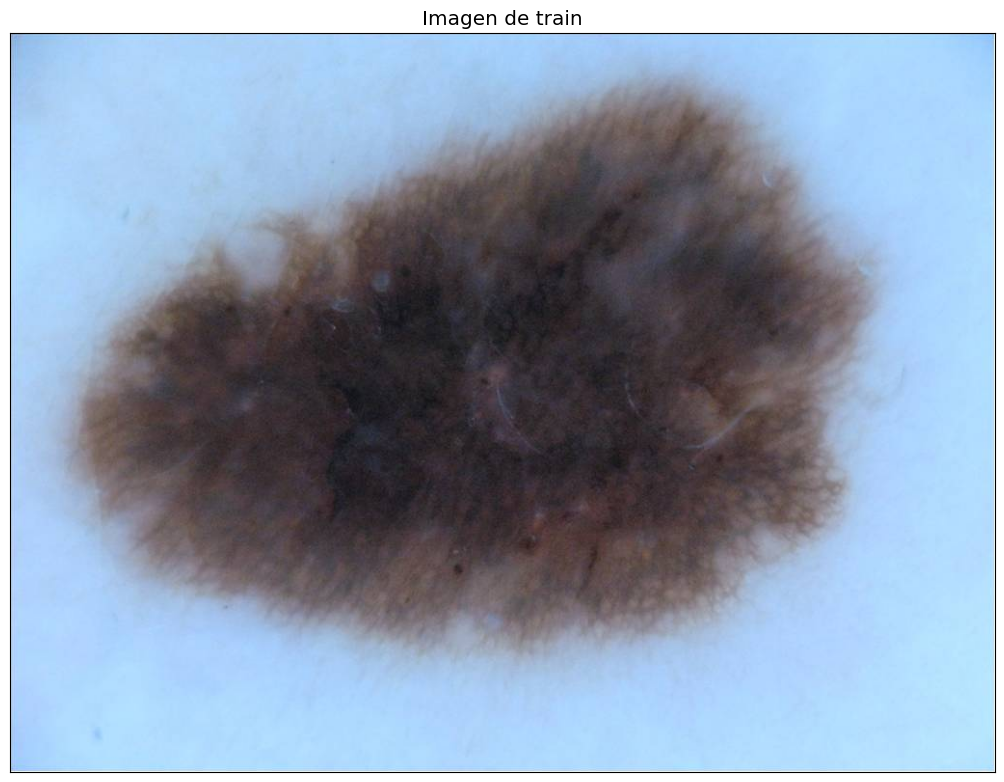

In [ ]:
imid = train.iloc[0]['image']
print(imid)
thumb = readIm(img_path + str(imid)+ ".jpg",1)
displayIm(thumb, title="Imagen de train")

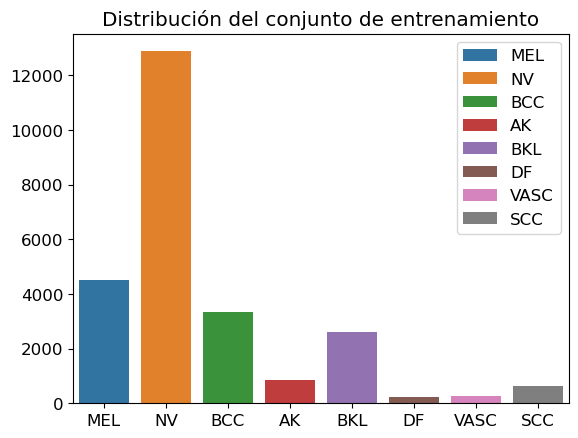

In [6]:
# Extraemos el conteo de cada clase
LABELS = ['MEL','NV','BCC','AK','BKL','DF','VASC','SCC']

train_y = train.iloc[:,1:-1].to_numpy()

# Representamos en un gráfico de barras
sns.barplot(x=LABELS, y=np.sum(train_y, axis=0), hue = LABELS,dodge=False)
plt.title("Distribución del conjunto de entrenamiento")
plt.show()

### Metadatos

In [ ]:
df_metadatados = pd.read_csv('ISIC_2019_Training_Metadata.csv')

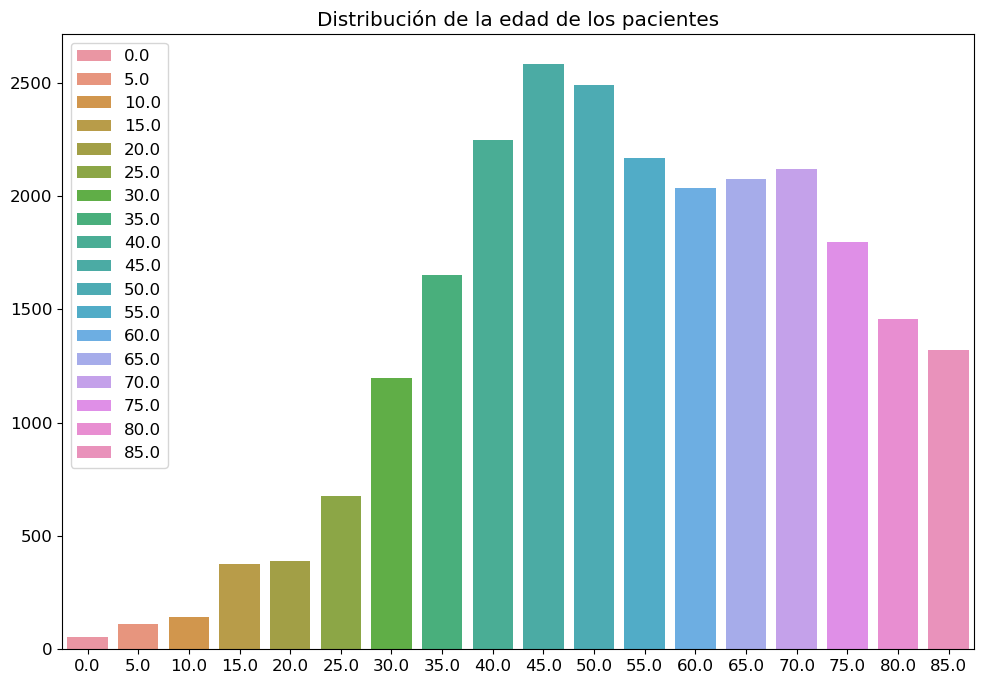

In [ ]:
# Extraemos el conteo de cada clase
labels = df_metadatados['age_approx'].unique()
lab_count = [sum(df_metadatados['age_approx'] == l) for l in labels]

# Representamos en un gráfico de barras
plt.figure(figsize=(10,7))
sns.barplot(x=labels, y=lab_count, hue = labels, dodge=False)
plt.title("Distribución de la edad de los pacientes")
plt.tight_layout()
plt.show()


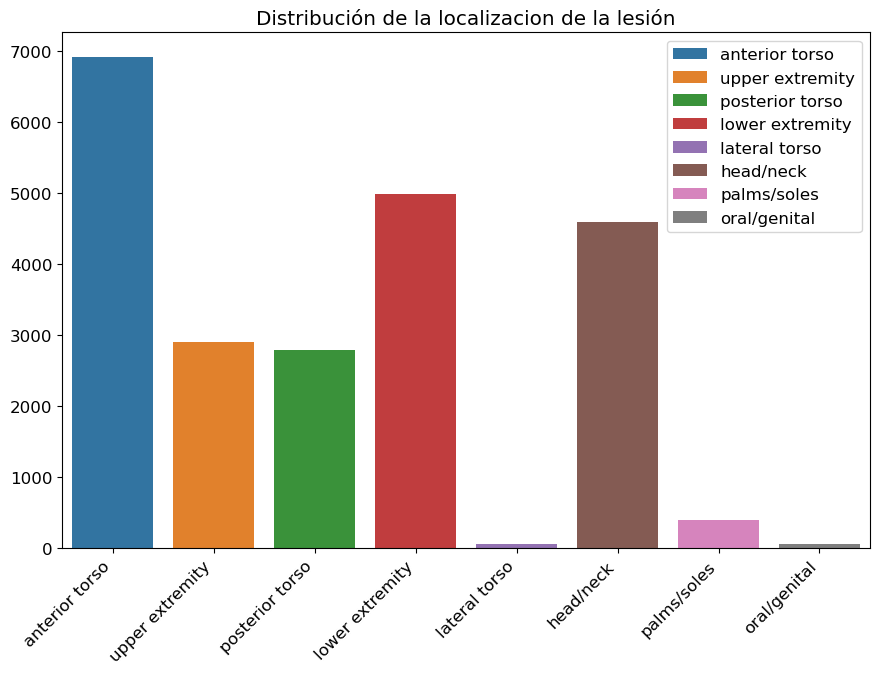

In [ ]:
# Extraemos el conteo de cada clase
labels = df_metadatados['anatom_site_general'].unique()
lab_count = [sum(df_metadatados['anatom_site_general'] == l) for l in labels]

# Representamos en un gráfico de barras
plt.figure(figsize=(9,6))
sns.barplot(x=labels, y=lab_count, hue = labels, dodge=False)
plt.title("Distribución de la localizacion de la lesión")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

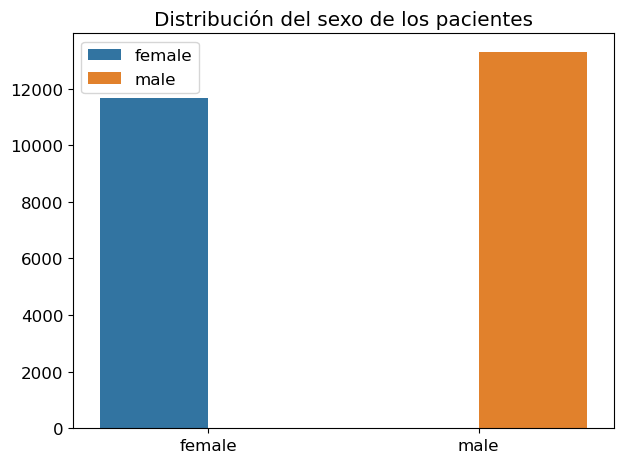

In [ ]:
# Extraemos el conteo de cada clase
labels = df_metadatados['sex'].unique()
lab_count = [sum(df_metadatados['sex'] == l) for l in labels]

# Representamos en un gráfico de barras
sns.barplot(x=labels, y=lab_count, hue = labels)
plt.title("Distribución del sexo de los pacientes")
plt.tight_layout()
plt.show()


In [1]:
def label_func(fname):
    print(fname)
    el = train.loc[train['image'] == (str(fname)[:-4].split("\\")[1])]
    return (LABELS[(np.argmax(el.to_numpy().squeeze()[2:-1]))])

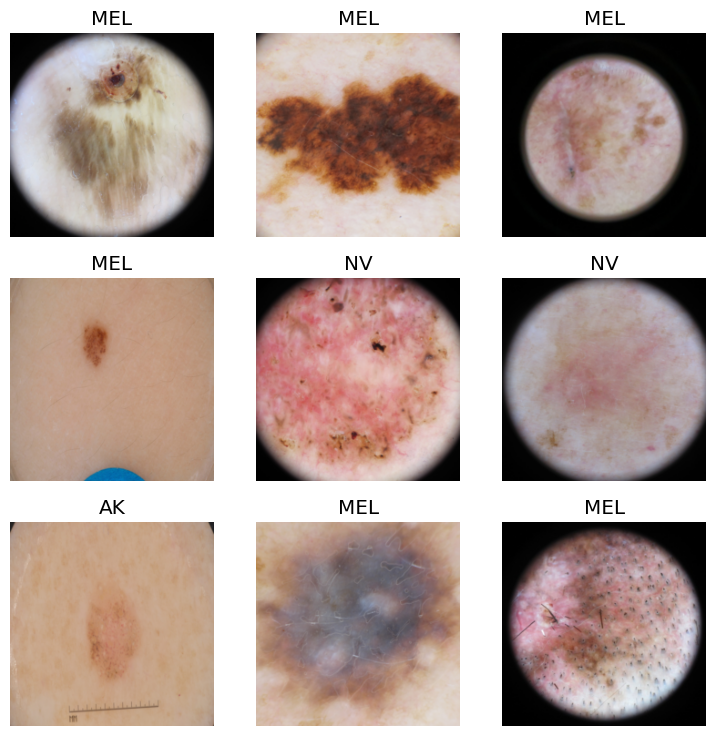

In [8]:
# División en 90% train y 10% validación
trainSet = DataBlock(
    blocks = (ImageBlock, CategoryBlock), # La entrada es un bloque de imagenes, y la salida, categorias
    get_items= get_image_files, # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter = RandomSplitter(valid_pct = 0.2, seed = 0), # Establecida semilla 0
    get_y = label_func,   # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms = [Resize(224, method='squish')],  # Redimensionado
).dataloaders("ISIC_2019_Training_Input/", bs=32)


trainSet.show_batch() # shows a batch of images

In [9]:
resnet_model = fastai.vision.models.resnet18
resnet_learner_fine = vision_learner(trainSet, resnet18, loss_func=FocalLossFlat(), metrics=[accuracy,error_rate])
resnet_learner_fine.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [10]:
resnet_learner_fine.fine_tune(epochs = 6, freeze_epochs= 12)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.333385,0.819707,0.668772,0.331228,08:05
1,0.779850,0.526523,0.749309,0.250691,05:56
2,0.583692,0.414573,0.766877,0.233123,05:43
3,0.460598,0.361568,0.775168,0.224832,05:49
4,0.416188,0.337110,0.778129,0.221871,05:48
5,0.358864,0.342669,0.781682,0.218318,05:56
6,0.360973,0.313175,0.791552,0.208448,05:40
7,0.332288,0.309644,0.788393,0.211607,05:48
8,0.300607,0.304974,0.792341,0.207659,05:48
9,0.323424,0.304560,0.796684,0.203316,05:40


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.257756,0.252989,0.823727,0.176273,05:48
1,0.223137,0.255590,0.833991,0.166009,05:48
2,0.148846,0.240639,0.837742,0.162258,05:48
3,0.072087,0.235787,0.858863,0.141137,05:48
4,0.022485,0.228204,0.871299,0.128701,05:48
5,0.013342,0.238100,0.869325,0.130675,05:48


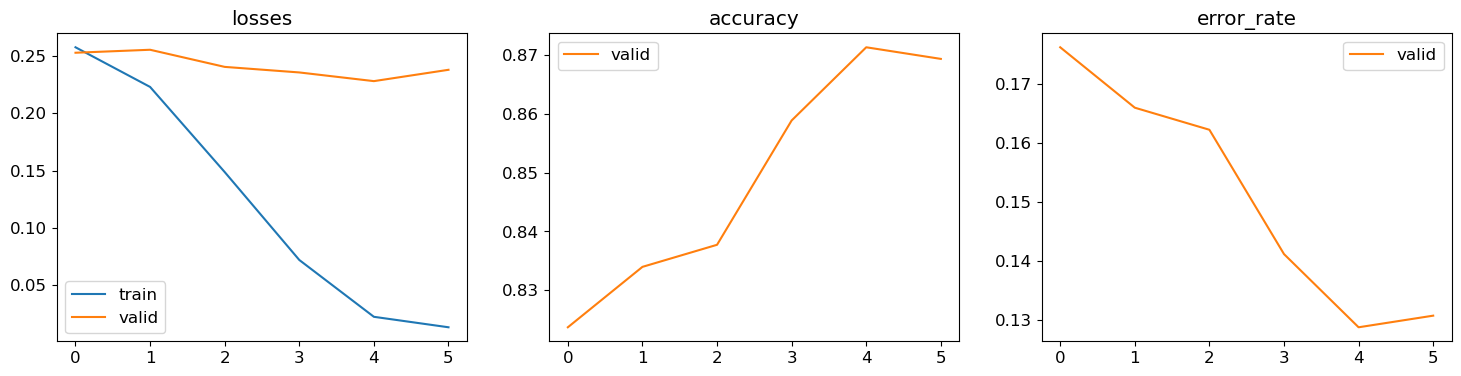

In [11]:
resnet_learner_fine.recorder.plot_metrics() #Muestra las pérdidas, el accuracy y la tasa de error

In [18]:
# We compute the confusion matrix
interp = ClassificationInterpretation.from_learner(resnet_learner_fine,1, trainSet.train)

Number of test examples: 20265


Train Accuracy
99.92104613866272


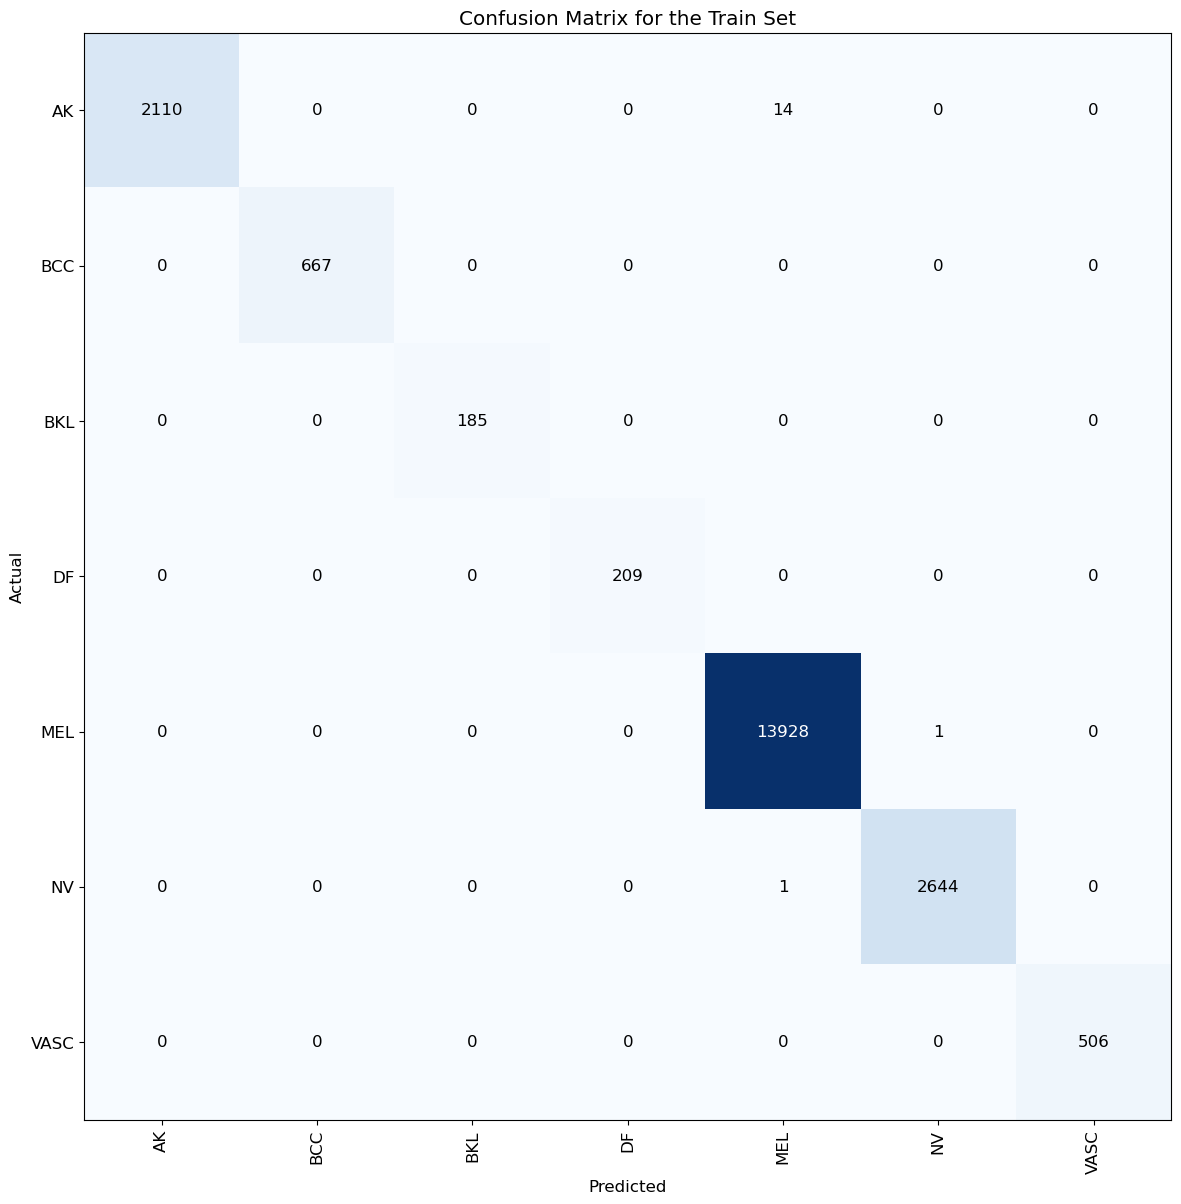

In [19]:
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Train Set')
print('Train Accuracy')
test_acc = np.sum(np.diagonal(cm))/np.sum(cm)*100
print(test_acc)

Number of valid examples: 20265


Valid Accuracy
99.92104613866272


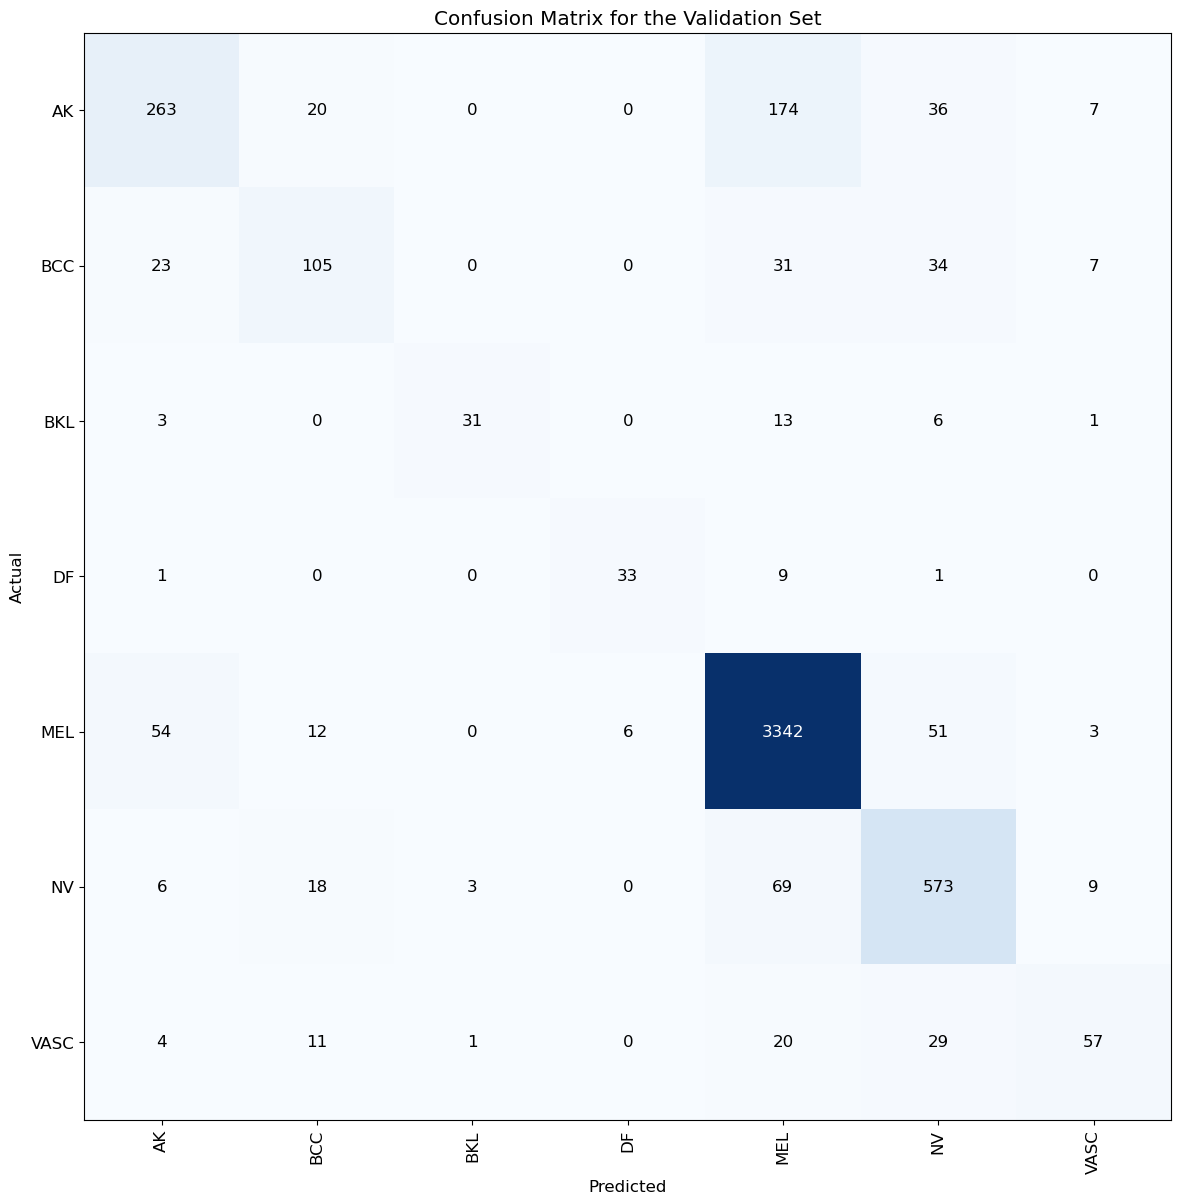

In [20]:
cm = interp.confusion_matrix()
interp = ClassificationInterpretation.from_learner(resnet_learner_fine,1, trainSet.valid)
print('Number of valid examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Validation Set')
print('Valid Accuracy')
test_acc = np.sum(np.diagonal(cm))/np.sum(cm)*100
print(test_acc)